In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import glob
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [2]:
# helper functions for log parsing

def pass_no_pass(lines):
    for line in lines:
        if "PASSED" in line:
            return True
        elif "FAILED" in line:
            return False
    return

def parse_fp_for_int_diff(lines):
    vals = {'expected': [], 'actual': []}
    delimiters = [" ", "\n"]
    for i in range(len(lines)):
        if "INT" in lines[i]:
            for delimiter in delimiters:
                line = " ".join(lines[i+1].split(delimiter))
            split = list(map(int, line.split()))
            if ("Expected value of" in lines[i]) and ("in" not in lines[i]):
                # print(lines[i])
                vals['expected'].append(split)
            elif "Last value of" in lines[i]:
                # print(lines[i])
                vals['actual'].append(split)

    diffs = []
    for i in range(len(vals['actual'])):
        for j in range(len(vals['actual'][i])):
            if vals['expected'][i][j] != vals['actual'][i][j]:
                diffs.append(int(vals['expected'][i][j]) - int(vals['actual'][i][j]))
    return diffs

def mask_errors(lines):
    errs = 0
    mask = False
    for line in lines:
        if "Error mask" in line:
            mask = True
            continue
        elif "SECTION" in line:
            if mask == True:
                return errs
        if mask:
            errs += sum([int(char) for char in line[:-1]])
    return errs

In [7]:
# create csv of testing logs
# change bool to generate csv if not created
gen_csv = True

def generate_csv():

    df = pd.DataFrame(columns=["kind", "run", "log", "lines", "time", "name", "path", "iters", "expected_vs_actual", "diff_count", "passed", "mask_errors"])

    for filename in glob.iglob('**', recursive=True):
        # TMP
        if "l1_static" not in filename:
            continue

        # skip exceptions, keep .txts with logs
        if "log" not in filename or filename[-4:] != ".txt" or "exception" in filename:
            continue
        tmp = filename.split('/')
        if not len(tmp) - 1:
            continue
        fp = open(filename, 'r')
        lines = fp.readlines()
        fp.close()

        kind, name = tmp[0], tmp[-1]

        # TODO: something with GXL logs
        if kind == "gxld":
            continue

        # get iteration count
        iter = [line for line in lines if "Exited" in line][0].split()[-1]
        # get count of i/o matches
        int_diff = parse_fp_for_int_diff(lines)
        # get pass/fail
        passed = pass_no_pass(lines)

        # mask errors
        msk_errs = mask_errors(lines)


        # parse datetime from file name
        try:
            time = datetime.strptime(filename[-21:-4], '%Y%m%d_%H-%M-%S') # everything but GXLD logs
        except Exception:
            try:
                time = datetime.strptime(filename[-18:-4], '%m-%d-%y_%H-%M') # specifically for GXLD logs
            except Exception as e:
                raise(e)
        
        # get 'run' and 'log' numbers
        runlog = name.split('_')[2]
        run, log = [int(x) for x in runlog.split('run')[-1].split('log')]

        row = {"kind": kind, "run":run, "log": log, "lines": len(lines), "iters": int(iter), "time": time, "name": name,\
            "path": filename, "expected_vs_actual": int_diff, "diff_count": len(int_diff), "passed": passed, "mask_errors": msk_errs}
        if df.name.str.contains(name).any():
            continue
        else:
            df.loc[len(df), :] = row
    df = df.sort_values(by=['kind', 'run', 'log']).reset_index(drop=True)
    df = df.astype({"time": "datetime64[ns]"})
    df = df.sort_values(by='time')
    df.to_csv("./results.csv", index=False)
if gen_csv:
    generate_csv()
logs = pd.read_csv("./results.csv")
logs = logs.astype({"time": "datetime64[ns]"})
tamu = pd.read_excel("./GSI_TAMU_202311_scrubbed.xlsx", skiprows=1)
tamu.columns = tamu.columns.str.replace(' ', '_').str.lower()
tamu = tamu.drop(len(tamu) - 1)

In [10]:
logs[logs.kind == 'l1_static']['mask_errors']

0        0
1     3055
2     3055
3     3055
4        0
5        0
6     3237
7     3237
8        0
9        0
10       0
11       0
12       0
13       0
14    3319
15    3319
16       0
17       0
Name: mask_errors, dtype: int64

In [11]:
tamu[tamu.test_mode == "L1 Static"]['seu_count_(16-bit_word_errors)']

0     3055
1     3237
27    3319
39    1658
49     908
61       0
62     NaN
63     NaN
64     NaN
65     NaN
66    2040
Name: seu_count_(16-bit_word_errors), dtype: object

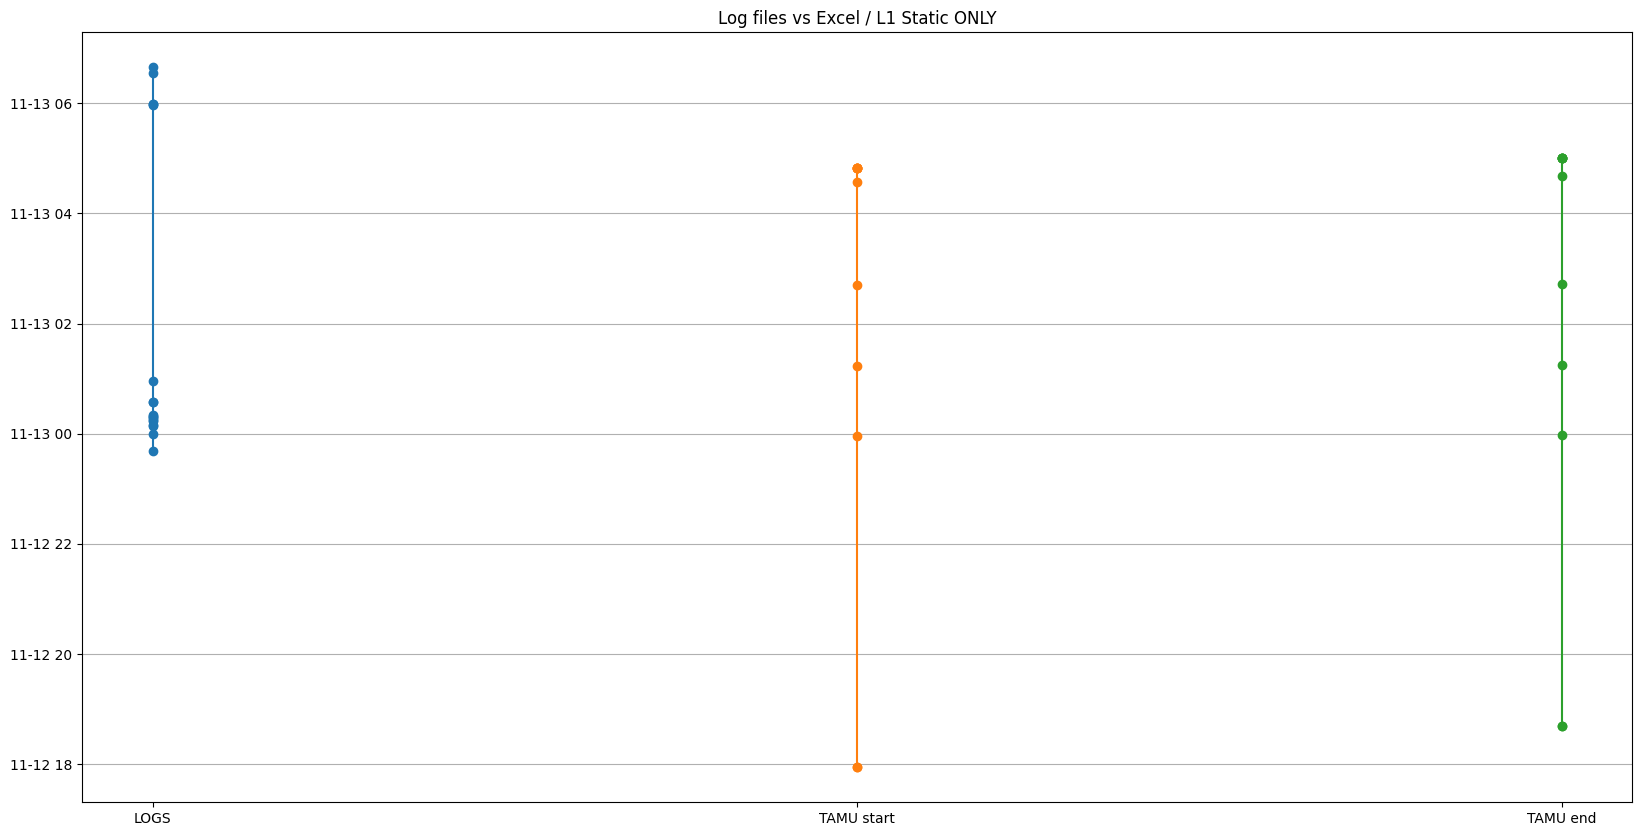

In [10]:
x = logs[logs.kind == 'l1_static'].reset_index(drop=True)
y = tamu[tamu.test_mode == "L1 Static"].reset_index(drop=True)
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(['LOGS']*x.shape[0], x['time'], marker='o')
ax.plot(["TAMU start"]*y.shape[0], y["run_start_date_and_time"], marker='o')
ax.plot(["TAMU end"]*y.shape[0], y['run_stop'], marker='o')
ax.set_title("Log files vs Excel / L1 Static ONLY")
plt.grid(axis='y')
plt.show()

In [24]:
# fig, ax = plt.subplots(figsize=(20,10))

tmp = pd.DataFrame(columns=x.time.dt.strftime("%d %H:%M:%S"))
for row in y.run_stop:
    tmp.loc[len(tmp), :] = list(map(lambda x: int(x.total_seconds()), row - x.time))
tmp = tmp.astype('int')
tmp.index=y.run_stop.dt.strftime("%d %H:%M:%S")
tmp

time,12 23:41:32,12 23:59:15,13 00:08:22,13 00:09:08,13 00:14:17,13 00:14:43,13 00:17:17,13 00:17:41,13 00:19:09,13 00:19:51,13 00:34:40,13 00:34:47,13 00:57:06,13 05:57:57,13 05:58:57,13 05:59:18,13 06:32:42,13 06:39:10
run_stop,,,,,,,,,,,,,,,,,,
12 18:41:25,-18007,-19070,-19617,-19663,-19972,-19998,-20152,-20176,-20264,-20306,-21195,-21202,-22541,-40592,-40652,-40673,-42677,-43065
12 18:41:25,-18007,-19070,-19617,-19663,-19972,-19998,-20152,-20176,-20264,-20306,-21195,-21202,-22541,-40592,-40652,-40673,-42677,-43065
12 23:58:45,1033,-30,-577,-623,-932,-958,-1112,-1136,-1224,-1266,-2155,-2162,-3501,-21552,-21612,-21633,-23637,-24025
13 01:14:59,5607,4544,3997,3951,3642,3616,3462,3438,3350,3308,2419,2412,1073,-16978,-17038,-17059,-19063,-19451
13 02:42:57,10885,9822,9275,9229,8920,8894,8740,8716,8628,8586,7697,7690,6351,-11700,-11760,-11781,-13785,-14173
13 04:40:41,17949,16886,16339,16293,15984,15958,15804,15780,15692,15650,14761,14754,13415,-4636,-4696,-4717,-6721,-7109
13 05:00:16,19124,18061,17514,17468,17159,17133,16979,16955,16867,16825,15936,15929,14590,-3461,-3521,-3542,-5546,-5934
13 05:00:16,19124,18061,17514,17468,17159,17133,16979,16955,16867,16825,15936,15929,14590,-3461,-3521,-3542,-5546,-5934
13 05:00:16,19124,18061,17514,17468,17159,17133,16979,16955,16867,16825,15936,15929,14590,-3461,-3521,-3542,-5546,-5934


In [224]:
tmp.iloc[:, 0]

0    -18007
1    -18007
2      1033
3      5607
4     10885
5     17949
6     19124
7     19124
8     19124
9     19124
10    19124
Name: 2023-11-12 23:41:32, dtype: int64

In [203]:
y.run_stop

0    2023-11-12 18:41:25
1    2023-11-12 18:41:25
2    2023-11-12 23:58:45
3    2023-11-13 01:14:59
4    2023-11-13 02:42:57
5    2023-11-13 04:40:41
6    2023-11-13 05:00:16
7    2023-11-13 05:00:16
8    2023-11-13 05:00:16
9    2023-11-13 05:00:16
10   2023-11-13 05:00:16
Name: run_stop, dtype: datetime64[ns]

In [7]:
masks = []
for path in df[df.kind == "mmb_dynamic"].path:
    lines = open(path).read().split('\n')
    mask, mask_bool = [], False
    for line in lines:
        if "mask" in line:
            mask_bool = True
            continue
        elif ("SECTION" in line) or (line == ""):
            mask_bool = False
        if mask_bool:
            mask.append(line)
    if len(mask): masks.append(mask)

In [114]:
f = open('/home/jacob/radTestLogBackup/mmb_static/log_staticMMBtest_run2log4_20231113_06-13-00.txt')
lines = f.read().split("\n")
f.close()

In [121]:
expected, actual = [], []
delimiters = [" ", "\n"]
for i in range(len(lines)):
    if "INT" in lines[i]:
        for delimiter in delimiters:
            line = " ".join(lines[i+1].split(delimiter))
        split = list(map(int, line.split()))
        split = list(map(lambda x: '{0:016b}'.format(x), split))
        if ("Expected value of" in lines[i]) and ("in" not in lines[i]):
            # print(lines[i])
            expected.append(split)
        elif "Last value of" in lines[i]:
            # print(lines[i])
            actual.append(split)
if not len(expected)-1:
    expected, actual = expected[0], actual[0]

In [19]:
! rm test_bits.txt
f = open("test_bits.txt", "a")
for i in range(len(masks[632])):
    f.write(masks[632][i])
    if i < len(masks[632]) - 1:
        f.write('\n')
f.close()